<h1> Advantage Actor Critic on continuous actions </h1>


<h3> Import dependencies </h3>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import torch
from torch import nn
import cloudpickle
import sklearn
from sklearn import preprocessing

<h3> Helper functions </h3>

In [9]:
def get_grads(model:torch.nn.Module):
    g = [param.grad.detach().flatten() for param in model.parameters() if param.grad is not None]
    g = torch.cat(g).detach().norm()
    if g > 100:
        print("High gradient")
    return g
def dump():
    with (open("./models/actor.pkl","wb") as f1, 
          open("./models/critic.pkl","wb") as f2, 
          open("./models/scaler.pkl","wb") as f3):
        cloudpickle.dump(actor,f1)
        cloudpickle.dump(critic,f2)
        cloudpickle.dump(scaler,f3)
def load():
    with (open("./models/actor.pkl","rb") as f1, 
          open("./models/critic.pkl","rb") as f2, 
          open("./models/scaler.pkl","rb") as f3):
        actor = cloudpickle.load(f1)
        critic = cloudpickle.load(f2)
        scaler = cloudpickle.load(f3)
        return actor,critic,scaler

<h3> Actor critic helper classes </h3>

In [7]:
class Actor:
    def __init__(self):
        self.pi = nn.Sequential(nn.Linear(2,50),
                  nn.ReLU(),
                  nn.Linear(50,2))
    def log_prob(self,state,action):
        dist =self._get_dist(state)
        return dist.log_prob(action),dist.entropy()
    
    def sample(self,state):
        dist =self._get_dist(state)
        _sample = dist.sample((1,))
        return _sample
    
    def _get_dist(self,state):
        mu,sigma = self.pi(state)
        sigma = torch.nn.Softplus()(sigma) + 1e-5
        dist = torch.distributions.Normal(mu,sigma)
        return dist

class Critic:
    def __init__(self):
        self.v = nn.Sequential(nn.Linear(2,100),
                  nn.ReLU(),
                  nn.Linear(100,1))
    
    def val(self,state):
        _val = self.v(state)
        return _val
    

<h3> Implementation of A2C </h3>

In [32]:
NUM_TRIALS = 1
NUM_EPISODES = 1000
ALPHA_V = 1e-3
ALPHA_PI = 1e-3
GAMMA = 0.99
env = gymnasium.make("MountainCarContinuous-v0")
returns = np.zeros((NUM_TRIALS,NUM_EPISODES))
ep_lens = np.zeros((NUM_TRIALS,NUM_EPISODES))
grads = [[],[]]
losses = [[],[]]
for i in range(NUM_TRIALS):
    actor = Actor()
    critic = Critic()
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(np.array([env.observation_space.sample() for _ in range(10000)]))
    mse_loss = nn.MSELoss()
    pi_op = torch.optim.SGD(actor.pi.parameters(),lr=ALPHA_PI)
    v_op = torch.optim.SGD(critic.v.parameters(),lr=ALPHA_V)
    for j in range(NUM_EPISODES):
        ret = 0.
        ep_len=0.
        state,*_ = env.reset()
        state = np.squeeze(scaler.transform([state]))
        state = torch.from_numpy(state).detach().float()
        while True:
            with torch.no_grad():
                action = actor.sample(state)
                #action = torch.clamp(action,env.action_space.low[0],env.action_space.high[0])
            next_state,reward,terminated,truncated,*_ = env.step(action)
            next_state = np.squeeze(scaler.transform([next_state]))
            next_state = torch.from_numpy(next_state).detach().float()
            with torch.no_grad():
                target = torch.tensor([reward]) + GAMMA * (critic.val(next_state) if not terminated else 0)
            v_op.zero_grad()
            est_v = critic.val(state)
            loss = mse_loss(target,est_v)
            loss.backward()
            v_op.step()
            losses[0].append(loss.detach().item())
            grads[0].append(get_grads(critic.v))
            with torch.no_grad():
                critic_est = torch.tensor([reward]) + GAMMA*(critic.val(next_state) if not terminated else 0) - critic.val(state)
            pi_op.zero_grad()
            prob = actor.log_prob(state,action)
            loss = (GAMMA**ep_len)*critic_est*prob[0]*-1 #The -1 is needed coz pytorch always does SGD and not ascent
            loss.backward()
            pi_op.step()
            losses[1].append(loss.detach().item())
            grads[1].append(get_grads(actor.pi))
            state = next_state
            ret+=reward
            ep_len+=1
            if terminated or truncated:
                if terminated:
                    print("\rAchieved target in",ep_len,"steps at ep",j,"with ret",ret,end="")
                break
        returns[i,j] = ret
        ep_lens[i,j] = ep_len
        

High gradient
Achieved target in 634.0 steps at ep 3 with ret 70.03981040108937High gradient
Achieved target in 936.0 steps at ep 8 with ret 60.324220584507934High gradient
Achieved target in 414.0 steps at ep 9 with ret 84.66582613375829High gradient
Achieved target in 430.0 steps at ep 10 with ret 80.69623404234831High gradient
Achieved target in 560.0 steps at ep 11 with ret 80.00292323145061High gradient
Achieved target in 589.0 steps at ep 12 with ret 79.44404624790505High gradient
Achieved target in 711.0 steps at ep 13 with ret 73.45042063130687High gradient
Achieved target in 413.0 steps at ep 14 with ret 75.79894568833254High gradient
Achieved target in 481.0 steps at ep 15 with ret 63.50000106742009High gradient
Achieved target in 283.0 steps at ep 16 with ret 70.62644348853037High gradient
Achieved target in 524.0 steps at ep 17 with ret 26.607652010511373High gradient
Achieved target in 234.0 steps at ep 18 with ret 68.39284913351945High gradient
Achieved target in 390.0 st

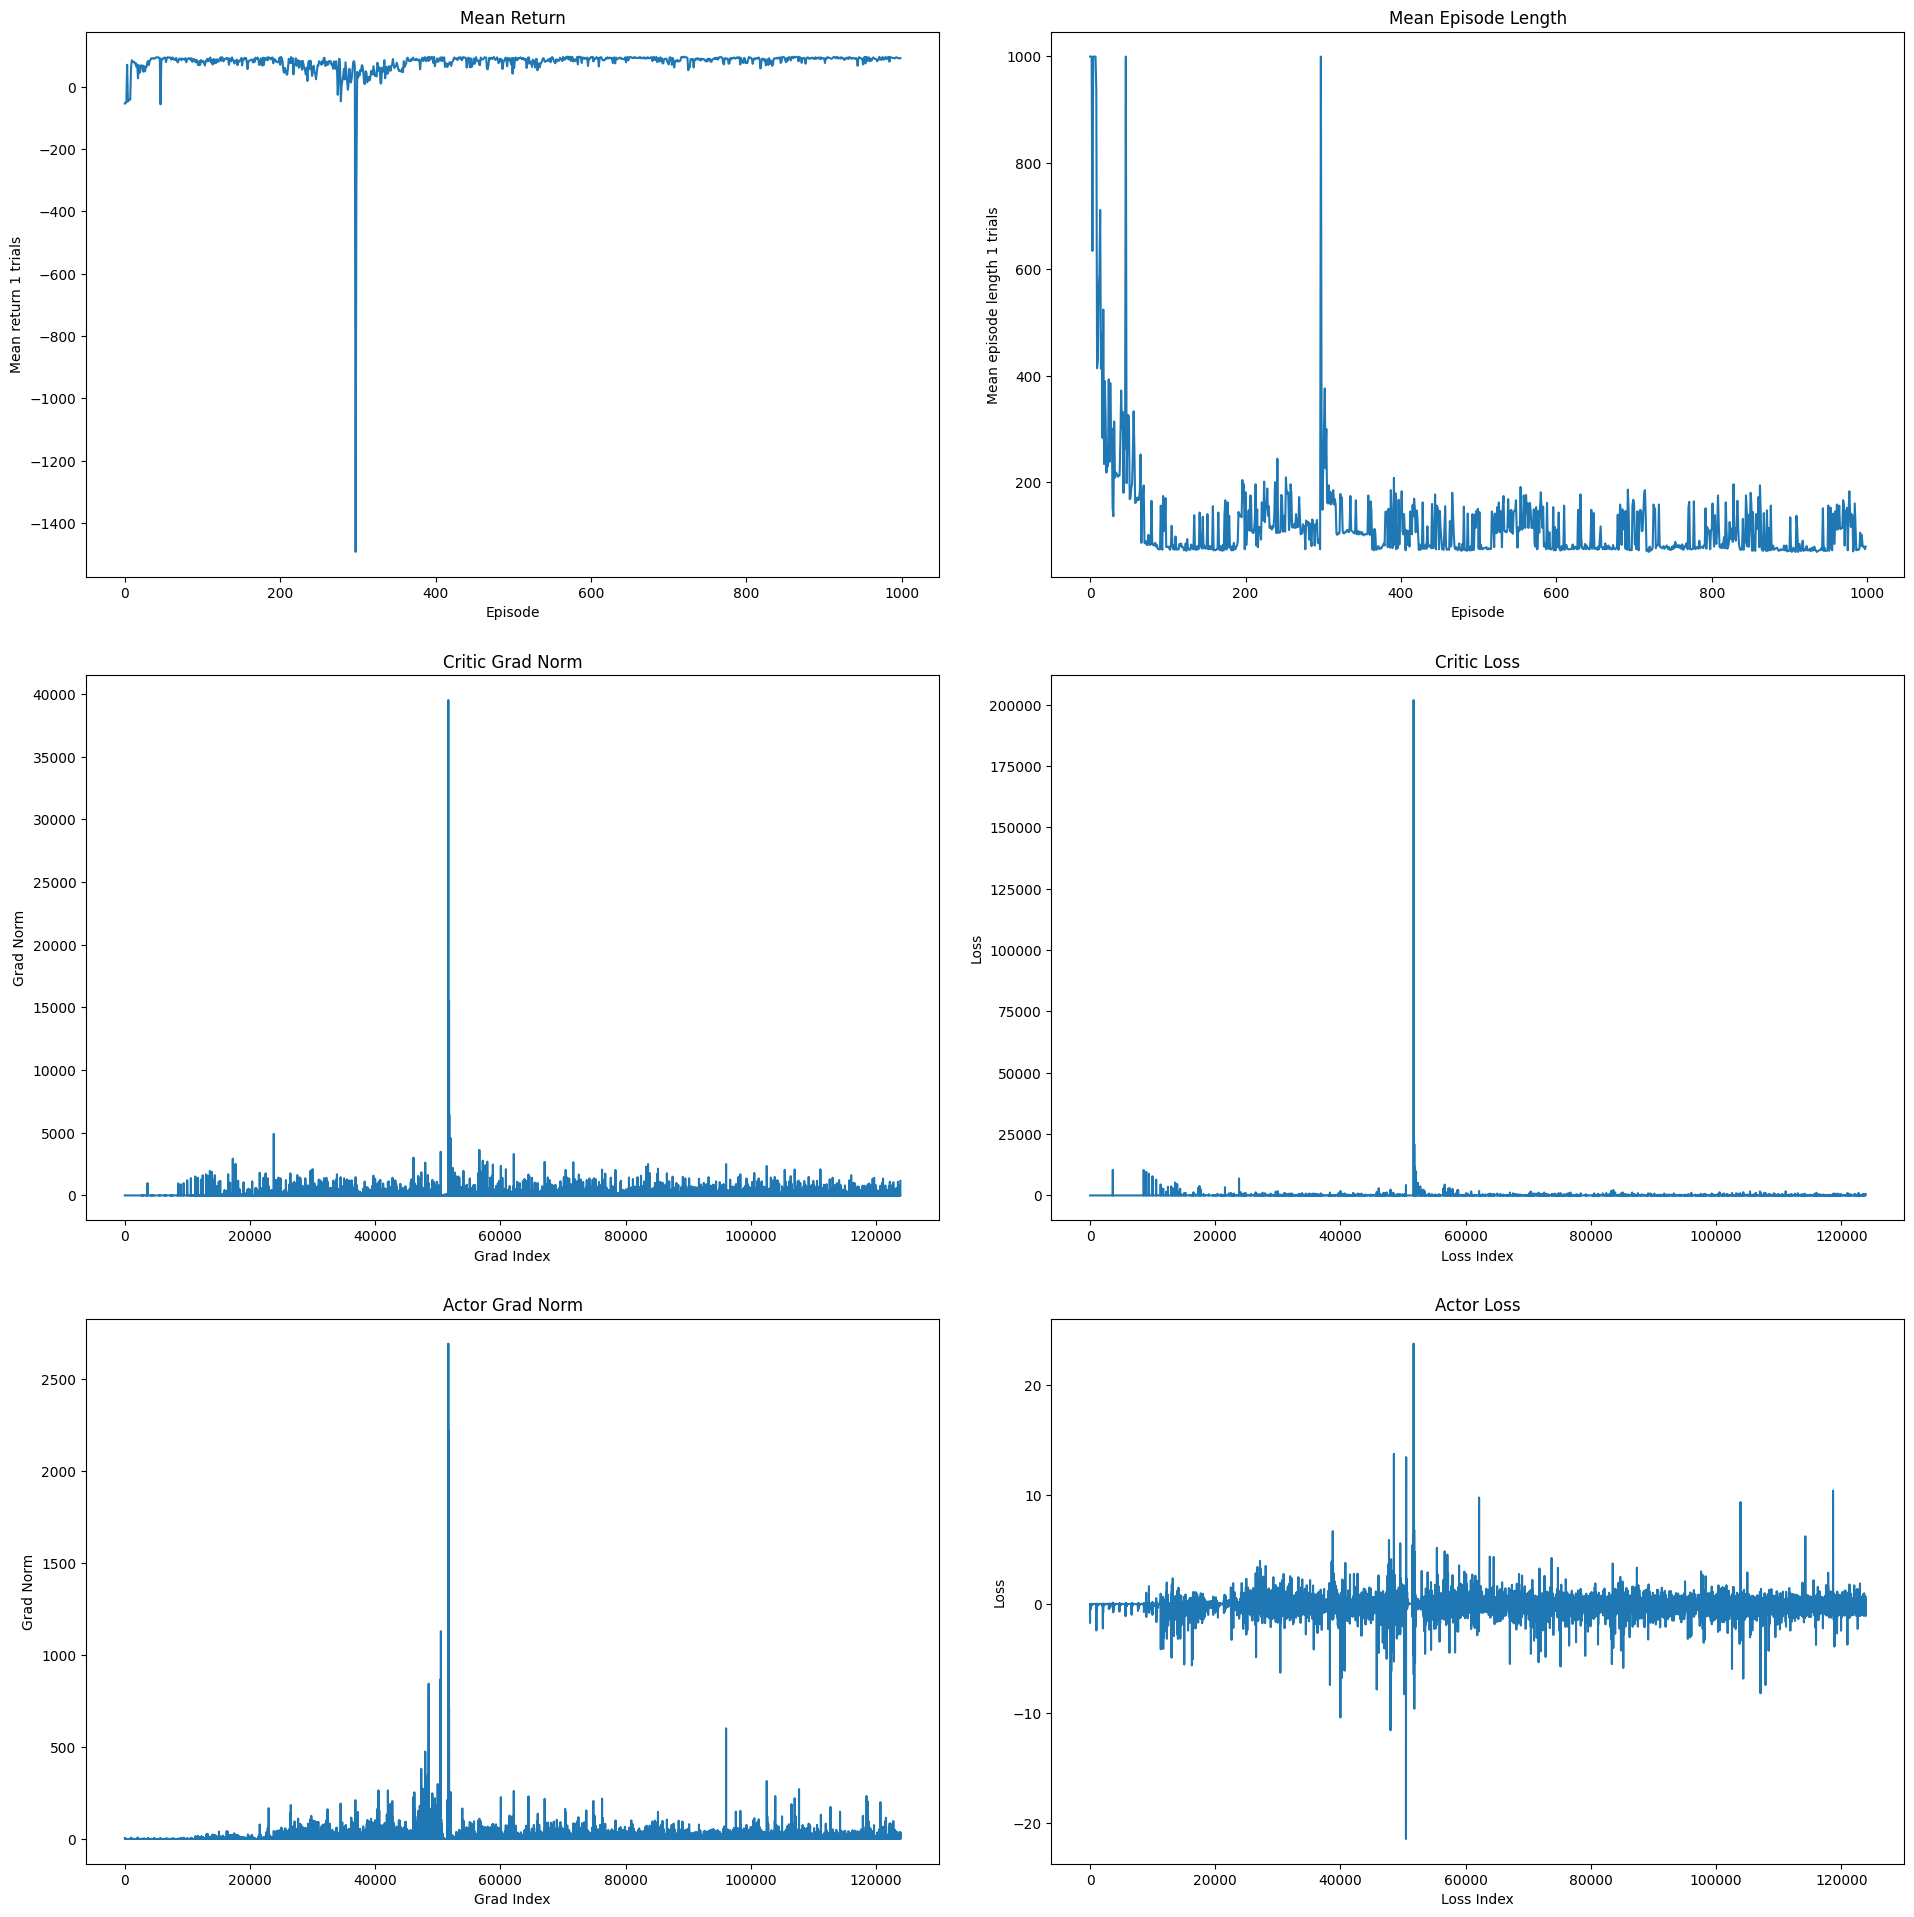

In [33]:
fig:Figure
ax1:Axes
ax2:Axes
ax3:Axes
ax4:Axes
ax5:Axes
ax6:Axes
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2)
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout(pad=5.0)
ax1.plot(returns[0][:j])
ax1.set_ylabel(f"Mean return {NUM_TRIALS} trials")
ax1.set_xlabel("Episode")
ax1.set_title("Mean Return")
ax2.plot(ep_lens[0][:j])
ax2.set_ylabel(f"Mean episode length {NUM_TRIALS} trials")
ax2.set_xlabel("Episode")
ax2.set_title("Mean Episode Length")
ax3.plot(grads[0])
ax3.set_ylabel(f"Grad Norm")
ax3.set_xlabel("Grad Index")
ax3.set_title("Critic Grad Norm")
ax4.plot(losses[0])
ax4.set_ylabel(f"Loss")
ax4.set_xlabel("Loss Index")
ax4.set_title("Critic Loss")
ax5.plot(grads[1])
ax5.set_ylabel(f"Grad Norm")
ax5.set_xlabel("Grad Index")
ax5.set_title("Actor Grad Norm")
ax6.plot(losses[1])
ax6.set_ylabel(f"Loss")
ax6.set_xlabel("Loss Index")
ax6.set_title("Actor Loss");

In [34]:
list(critic.v.parameters())[0]

Parameter containing:
tensor([[ 1.5711e-01,  1.1420e-02],
        [-8.2453e-02,  2.1620e-02],
        [-3.2897e-01,  2.6703e+00],
        [-1.0529e+00,  1.1883e+00],
        [ 4.6552e-03, -1.8662e-01],
        [-5.5758e-01, -7.1335e-02],
        [-9.0225e-01, -2.1205e+00],
        [-1.8328e+00,  6.1562e-01],
        [ 1.0316e+00,  8.4504e-01],
        [ 9.7263e-01,  3.3955e-01],
        [-1.0773e-01,  9.3517e-02],
        [-7.1239e-01, -4.6267e-01],
        [-3.6709e-01, -1.8035e+00],
        [-5.0525e-01, -4.8890e-01],
        [-1.2108e+00, -1.8299e+00],
        [ 3.5871e-01,  1.7917e+00],
        [-1.6853e+00,  3.8419e-01],
        [-7.7322e-01,  2.2599e-01],
        [-2.3725e-01,  1.8017e+00],
        [ 3.9218e-01, -4.7096e-01],
        [ 4.0684e-01, -2.3234e-01],
        [-1.1468e+00, -3.2032e-01],
        [ 1.7603e-01, -5.9865e-02],
        [-2.8112e-01, -3.1383e-01],
        [ 8.6896e-01,  7.4012e-01],
        [ 1.3007e-01,  3.8708e-01],
        [-3.1387e+00,  1.9412e+00],
      

In [35]:
list(actor.pi.parameters())[0]

Parameter containing:
tensor([[ 0.2221,  0.0306],
        [ 0.2866,  0.0460],
        [ 0.0598, -0.6871],
        [-0.1422,  0.2730],
        [-0.4889, -0.0721],
        [-0.0529, -0.1405],
        [ 0.2068, -0.1152],
        [ 0.1226, -0.2393],
        [ 0.1487,  0.2948],
        [-0.7352, -0.3894],
        [ 0.1581, -0.1115],
        [ 0.1975,  0.4341],
        [-0.2194, -0.3058],
        [ 0.3650,  0.0161],
        [ 0.1168,  0.2110],
        [-0.0428, -0.6423],
        [-0.4417,  0.3849],
        [ 0.3816, -0.4962],
        [ 0.2253, -0.1857],
        [-0.2858, -0.4274],
        [-0.3181, -0.0677],
        [ 0.0637,  0.0894],
        [ 0.0209, -0.1109],
        [-0.1442,  0.5390],
        [ 0.1505, -0.0478],
        [-0.0271,  0.5600],
        [-0.3610,  0.3067],
        [ 0.0216, -0.8126],
        [ 0.0665, -0.0249],
        [ 0.2927,  0.2285],
        [ 0.0296, -0.4906],
        [ 0.0903, -0.0911],
        [-0.1128,  0.4204],
        [-0.1171, -0.0355],
        [ 0.4154, -0.3126]

In [36]:
returns[:][:j]

array([[  -54.54494681,   -50.74203322,   -50.84213432,    70.0398104 ,
          -47.61010462,   -43.94877535,   -41.93094828,   -41.97438584,
           60.32422058,    84.66582613,    80.69623404,    80.00292323,
           79.44404625,    73.45042063,    75.79894569,    63.50000107,
           70.62644349,    26.60765201,    68.39284913,    44.44094293,
           50.32111385,    68.44799991,    64.79322006,    67.67787133,
           47.68934515,    65.12816481,    49.09100857,    63.71597691,
           62.71985124,    78.33925218,    82.05963446,    69.12339241,
           82.80248805,    85.83524892,    90.85123293,    90.86092766,
           91.39875208,    89.62554786,    89.00812603,    91.24076695,
           93.7044341 ,    94.0191612 ,    93.67196281,    94.16374712,
           92.30965576,    91.56799658,   -56.91078513,    87.29664544,
           86.61402162,    90.61397581,    90.69124273,    93.06178926,
           92.91716954,    78.4079916 ,    89.872929  ,    94.45

In [37]:
dump()

<h3> Evaluate in human render mode </h3>

In [42]:
actor,critic,scaler = load()
env = gymnasium.make("MountainCarContinuous-v0",render_mode="human")
state,*_ = env.reset()
for _ in range(1):
    while True:
        state = np.squeeze(scaler.transform([state]))
        state = torch.from_numpy(state).detach().float()
        with torch.no_grad():
            action = actor.sample(state)
        next_state,reward,terminated,truncated,*_ = env.step(action)
        if terminated or terminated:
            break
        state = next_state